The source dataset is Rplan Dataset, it is a dataset consists of about 80k floor plans as images.

First, we converted the image based RPlan dataset to a geometry based dataset in another notebook.

In this notebook, we will create a custom dataset as a networkx graphs from the Rplan floor plans. So, we could use it to train the GAT-Net model to predict the room bounding boxes width and height.

In [ ]:
!pip3 install shapely==2.0.0 --quiet
!pip3 install geopandas --quiet
!pip3 install distinctipy --quiet
!pip3 install pickle5 --quiet
!pip3 install networkx --quiet

import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Dataset Construction


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


import geopandas as gpd
import pickle as pickle

from collections.abc import Iterable
from tqdm import tqdm
import os


import shapely
from shapely import affinity, MultiPolygon, GeometryCollection, Polygon, ops, LineString, unary_union, intersection_all
import geopandas as gpd

import pandas as pd
from pandas.core.series import Series
import networkx as nx

import distinctipy
import random

data_url = "/content/drive/MyDrive/RPlanify_dataset/planify/train.pickle"

In [ ]:
with open(data_url, "rb") as fh:
    df = pickle.load(fh)

for col in df.columns:
    df[col] = df[col].apply(lambda x: x if x and len(x.geoms) else None)

df = df.rename(columns={
    'interior_area': 'inner',
    'exterior_wall_2': 'outer_wall',
    'interior_wall': 'inner_wall',
    'second': 'second_room'
})


geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

only_rooms =  ['living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'entrance']


needed_columns = only_rooms + ['front_door', 'interior']

df.count()

living           80788
master           79536
kitchen          77628
bathroom         80707
dining            1311
child             3874
study            14960
second_room      76893
guest              826
balcony          67630
entrance           288
storage           3296
wall-in           1030
external         80788
exterior_wall    80788
front            80787
inner_wall       80788
interior         80737
front_door       80787
outer_wall       80788
inner            80788
dtype: int64

In [ ]:
def plot_colors_dict(colors):
    n = len(colors)
    ncols = 4
    nrows = n // ncols + 1

    fig, ax = plt.subplots(figsize=(9, 2))

    X, Y = fig.get_dpi() * fig.get_size_inches()
    h = Y / (nrows + 1)
    w = X / ncols

    for i, name in enumerate(colors):
        col = i % ncols
        row = i // ncols
        y = Y - (row * h) - h

        xi_line = w * (col + 0.05)
        xf_line = w * (col + 0.25)
        xi_text = w * (col + 0.3)

        ax.text(xi_text, y, name, fontsize=(h * 0.8),
                horizontalalignment='left',
                verticalalignment='center')
        ax.hlines(y + h * 0.1, xi_line, xf_line,
                  color=tuple([*colors[name]/255, 1]), linewidth=(h * 0.6))

    ax.set_xlim(0, X)
    ax.set_ylim(0, Y)
    ax.set_axis_off()

    fig.subplots_adjust(left=0, right=1,
                        top=1, bottom=0,
                        hspace=0, wspace=0)
    plt.show()


def imshow(img, fig_size=(500, 500)):
    """ Plot an image

    Parameters
    ----------
    img: ndarray (OpenCV image) or PIL.Image
        The image to be plotted
    fig_size: tuple
        The figure size
    """
    try:
        img = Image.fromarray(img)
    except:
        try:
            img = img.astype(np.uint8)
        except:
            ...
    display(img.resize(fig_size))

In [ ]:
# Generating random colors with a unified seed
random.seed(2000)
N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [ ]:
def get_mask(poly, shape):

    img = np.zeros(shape, dtype=np.uint8)
    if isinstance(poly, Polygon):
        img = cv2.drawContours(img, np.int32([poly.exterior.coords]), -1, 255, -1)

    elif isinstance(poly, MultiPolygon):
        for p in poly.geoms:
            img = cv2.drawContours(img, np.int32([p.exterior.coords]), -1, 255, -1)
    elif isinstance(poly, Series):
        polys = [p for p in poly.tolist() if p]
        img = get_mask(polys, shape)

    elif isinstance(poly, Iterable):
        for p in poly:
            img = (img != 0) | (get_mask(p, shape) != 0)
        img = img.astype(np.uint8) * 255

    return img.astype(np.uint8)



def plot_plan_colored(index=None, idf=df, row=None, shape=(255, 255),
                      return_img=False, points=None, radius=5,
                      rooms_columns=geoms_columns):


    img  = np.zeros((*shape, 3), dtype=np.uint8)
    if row is None:
        if index is not None:
            row = idf.iloc[index]
        else:
            return

    for i, room_name in enumerate(rooms_columns):
        color = room_color[room_name]
        room_geo = row[room_name]
        if room_geo is not None:
            mask = get_mask(room_geo, shape)
            img[np.where(mask > 0)] = color
    if points:
        for p in points:
            cv2.circle(img, (int(p[0]), int(p[1])), radius, (255, 255, 255), thickness=-1)

    imshow(img)
    if return_img:
        return img

def plot_plan_list_colored(plan_list, shape=(255, 255),
                      return_img=False, points=None, radius=5):


    img  = np.zeros((*shape, 3), dtype=np.uint8)

    for i, (room_name, polygon) in enumerate(plan_list):
        color = room_color[room_name]
        room_geo = polygon
        if room_geo is not None:
            mask = get_mask(room_geo, shape)
            img[np.where(mask > 0)] = color
    if points:
        for p in points:
            cv2.circle(img, (int(p[0]), int(p[1])), radius, (255, 255, 255), thickness=-1)

    imshow(img)
    if return_img:
        return img


def get_real_area(mpoly, base_img_area=256*256, orig_area=18*18):


    return orig_area * mpoly.area / base_img_area

In [ ]:
idx = 3977

interior = df.iloc[idx]['inner']
wall = df.iloc[idx]['outer_wall']

interior_and_wall = interior.union(wall)

get_real_area(interior_and_wall)

111.81005859375

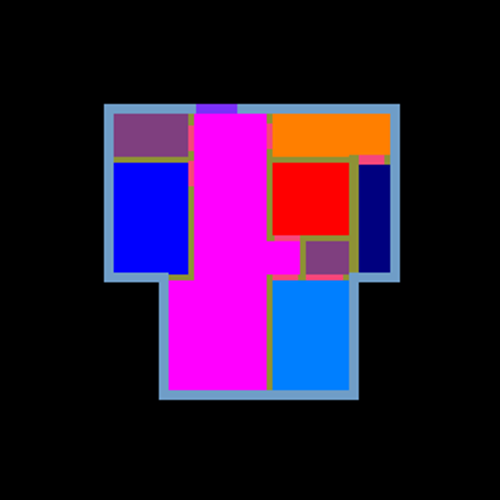

In [ ]:
plot_plan_colored(900)


In [ ]:
# I considered there is a plan with no front_door
df[df['front_door'].isna()]

,living,master,kitchen,bathroom,dining,child,study,second_room,guest,balcony,...,storage,wall-in,external,exterior_wall,front,inner_wall,interior,front_door,outer_wall,inner
66540,"MULTIPOLYGON (((109 92, 109 132, 126 132, 127 ...","MULTIPOLYGON (((109 136, 109 148, 107 150, 106...","MULTIPOLYGON (((186 40, 186 88, 201 88, 201 40...","MULTIPOLYGON (((66 124, 66 145, 105 145, 105 1...","MULTIPOLYGON (((137 29, 137 39, 136 40, 127 40...",None,None,"MULTIPOLYGON (((78 40, 78 88, 123 88, 123 40, ...",None,"MULTIPOLYGON (((87 29, 87 36, 133 36, 133 29, ...",...,None,None,"MULTIPOLYGON (((0 0, 0 255, 255 255, 255 0, 0 ...","MULTIPOLYGON (((84 26, 84 36, 83 37, 75 37, 75...",None,"MULTIPOLYGON (((66 121, 66 123, 105 123, 106 1...","MULTIPOLYGON (((106 92, 106 120, 108 120, 108 ...",None,"MULTIPOLYGON (((84 26, 84 36, 83 37, 75 37, 75...","MULTIPOLYGON (((87 29, 87 39, 86 40, 78 40, 78..."


In [ ]:

# Number of floor plans befor droping it is
df.shape[0]

80788

In [ ]:
df = df.dropna(subset=['front_door'])
df = df.reset_index()
# Now, number of floor plans is
df.shape[0]

80787

In [ ]:
# df_rooms_polys = df[only_rooms].apply(lambda r: sum({room_name: list(mp.geoms) if mp else [] for room_name, mp in r.todict().items()})
def get_rooms_polygons(cell):
    ''' apply function for dataframe to convert MultiPolygons to a list of Polygons'''
    return list(cell.geoms) if cell is not None else []

df_rooms_polys = df[needed_columns].applymap(get_rooms_polygons)

In [ ]:
def get_rooms_polygons_dict(row):
    ''' apply function for dataframe toa get dict of rooms and their polygons'''
    return row.to_dict()

df_rooms_polys_dict = df_rooms_polys.apply(get_rooms_polygons_dict, axis=1)

In [ ]:
# embedding room type as intergers
embedings = {}
for i, type_ in enumerate(df_rooms_polys_dict[0].keys()):
    embedings[type_] = i
embedings

{'living': 0,
 'master': 1,
 'kitchen': 2,
 'bathroom': 3,
 'dining': 4,
 'child': 5,
 'study': 6,
 'second_room': 7,
 'guest': 8,
 'balcony': 9,
 'storage': 10,
 'entrance': 11,
 'front_door': 12,
 'interior': 13}

In [ ]:
def createGraph(Graph_index, living_to_all=False, all_conected=False):
    """
    Generating a graph for a specific floor plan

    Input:
        Graph_index: Index of the floo plan.

    Output:
        G: a networkx graph.

    """
    # floor_plan: a dictionary [key: type of room, value: its data]
    floor_plan = df_rooms_polys_dict[Graph_index]

    # Creating new graph
    G = nx.Graph()

    # getting the threshould of buffering each room with the inner_doors sizes to see its Adjs.
    n = len(floor_plan['interior'])
    summation = 0
    if n != 0: # if there are inner doors
        for i in range(n):
            x1, y1, x2, y2 = floor_plan['interior'][i].bounds
            res1, res2 = x2 - x1, y2 - y1
            summation += min(res1, res2)

    else: # if there is no inner doors, take the outer.
        n = 1
        x1, y1, x2, y2 = floor_plan['front_door'][0].bounds
        res1, res2 = x2 - x1, y2 - y1
        summation += min(res1, res2)

    threshold = summation / n

    # Embeding each room in a node.
    for type_, mPoly in floor_plan.items():
        # Not encloding balcony as the model of getting centroids doesn't support balconies
        if (len(mPoly) == 0) or (type_ in ['interior', 'front_door', 'balcony', 'storage', 'entrance']):
            continue

        else:
            for i, poly1 in enumerate(mPoly):

                x_min, y_min, x_max, y_max= poly1.bounds
                rec_w, rec_h = x_max - x_min, y_max - y_min
                currentNodeName = f'{type_}_{i}'

                # The following if statement done as the model of getting centroids doesn't support living.
                # if type_ == 'living':
                #     center_x = df['inner'][Graph_index].centroid.x
                #     center_y = df['inner'][Graph_index].centroid.y
                # else:
                center_x = poly1.centroid.coords[0][0]
                center_y = poly1.centroid.coords[0][1]

                G.add_node(currentNodeName,
                    roomType_name = type_,
                    roomType_embd = embedings[type_],
                    actualCentroid_x = center_x,
                    actualCentroid_y = center_y,
                    rec_w            = rec_w,
                    rec_h            = rec_h,
                    roomSize = poly1.area / df['inner'][Graph_index].area)


                # Creating edges between rooms.
                if (not living_to_all) and (not all_conected) :
                    for type__, mPoly_ in floor_plan.items():
                        if (len(mPoly_) == 0) or (type__ in ['interior', 'front_door', 'balcony', 'storage', 'entrance']):
                            continue
                        else:
                    # print(type__, mPoly_, len(mPoly_))
                            for j, poly2 in enumerate(mPoly_):
                                if poly2 == poly1:
                                    continue
                                else:
                                    p1 = poly1.buffer(threshold)
                                    p2 = poly2.buffer(threshold)

                                    if p1.intersects(p2):
                                        adjNodeName = f'{type__}_{j}'

                                        dis = poly1.centroid.distance(poly2.centroid)
                                        G.add_edge(currentNodeName, adjNodeName, distance=round(dis, 3))


    # if we need to connect all rooms to the living
    if living_to_all:
        living_cen = shapely.Point(G.nodes['living_0']['actualCentroid_x'], G.nodes['living_0']['actualCentroid_y'])
        for node in G.nodes():
                if G.nodes[node]['roomType_name'] != 'living':
                    point = shapely.Point(G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y'])
                    dis = living_cen.distance(point)
                    # adding edges between the living and all geoms
                    G.add_edge('living_0', node, distance=round(dis, 3))


    # if we need to connect all geoms to each others
    if all_conected:
        for node in G.nodes():
            current_node_centeroid = shapely.Point(G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y'])

            for other_node in G.nodes():
                if other_node != node: # for all other rooms
                    other_node_centeroid = shapely.Point(G.nodes[other_node]['actualCentroid_x'], G.nodes[other_node]['actualCentroid_y'])

                    dis = current_node_centeroid.distance(other_node_centeroid)
                    # adding edges between the the current node and the other nodes
                    G.add_edge(node, other_node, distance=round(dis, 3))

    return G

In [ ]:
def draw_graph_nodes(G, living_to_all=False):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}

    scales = [G.nodes[node]['roomSize'] * 10000 for node in G]
    color_map = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    edge_labels = nx.get_edge_attributes(G, 'distance')


    nx.draw_networkx_nodes(G, pos=pos, node_size=scales, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos, edge_color='b');
    nx.draw_networkx_labels(G, pos=pos, font_size=8);

    if living_to_all:
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


    # # Drawing the graph inside a good boundary.
    # x_coords  = [pos[node][0] for node in pos]
    # y_coords  = [pos[node][1] for node in pos]
    # threshold = max(scales) / 100

    # plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)

In [ ]:
def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}

    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]

    # nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)
    nx.draw_networkx_nodes(G, pos=pos, node_size=150, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos)

    plt.xlim(-10, 266)
    plt.ylim(-266, 10)

In [ ]:
# Coordinates of the boundary
coords = df.inner[2].geoms[0].exterior.coords[:]

# creating points:
points = []
for p in coords:
    points.append(shapely.Point(p))

# Start of Handling
graph = nx.Graph()
graph.add_node(0, type=0, centroid=coords[0])
print('0 is Done', '\n', '='*50)

# to save the index if there is a node will not be added
current = 0
name = 1

for i in range(1, len(coords)):
    print(f'num_of_nodes: {len(graph)}')
    dis = points[i].distance(points[current])
    print(i, current, '--> ', dis )
    if dis >= 5:
        print(i, 'Done')
        graph.add_node(name, type=0, centroid=coords[i])
        current = i
        name += 1

    else:
        print(i, 'Not-Done')

    print('='*50)


# Checking the distance between first and last node [if the distance is small, so we will consider them the same point]
nodes_names = list(graph.nodes)
print(graph.nodes[nodes_names[0]])
print(f'Number of nodes now: {len(nodes_names)}')
first_node = shapely.Point(graph.nodes[nodes_names[0]]['centroid'])
last_node  = shapely.Point(graph.nodes[nodes_names[-1]]['centroid'])
if first_node.distance(last_node) <= 5:
    graph.remove_node(nodes_names[-1])
    nodes_names = list(graph.nodes)
    print(f'Num of nodes after removing: {len(nodes_names)}')


points = []
for node in graph:
    points.append(shapely.Point(graph.nodes[node]['centroid']))

# Adding edges between nodes.
for i in range(len(nodes_names)-1):
    dis = points[i].distance(points[i+1])
    graph.add_edge(nodes_names[i],nodes_names[i+1], distance=dis)

# Adding an edge between the last and the first nodes.
dis = points[nodes_names[0]].distance(points[nodes_names[-1]])

graph.add_edge(nodes_names[0], nodes_names[-1], distance=dis)

0 is Done 
num_of_nodes: 1
1 0 -->  15.0
1 Done
num_of_nodes: 2
2 1 -->  1.4142135623730951
2 Not-Done
num_of_nodes: 2
3 1 -->  97.0051545022222
3 Done
num_of_nodes: 3
4 3 -->  62.0
4 Done
num_of_nodes: 4
5 4 -->  189.0
5 Done
num_of_nodes: 5
6 5 -->  54.0
6 Done
num_of_nodes: 6
7 6 -->  1.4142135623730951
7 Not-Done
num_of_nodes: 6
8 6 -->  13.038404810405298
8 Done
num_of_nodes: 7
9 8 -->  23.0
9 Done
num_of_nodes: 8
10 9 -->  105.0
10 Done
{'type': 0, 'centroid': (124.0, 89.0)}
Number of nodes now: 9
Num of nodes after removing: 8


In [ ]:
def adding_door(boundary_graph, index, points):

    door = df['front_door'][index]
    nearest_edge = None
    nearest_dist = float('inf')

    dx = door.bounds[2] - door.bounds[0]
    dy = door.bounds[3] - door.bounds[1]
    door_oriantation_horizontal = dx > dy

    for edge in boundary_graph.edges():
        p1 = points[edge[0]]
        p2 = points[edge[1]]

        line = shapely.LineString([p1, p2])

        # checking the oriantation of the lines.
        p1x, p1y = p1.x, p1.y
        p2x, p2y = p2.x, p2.y
        dx = abs(p2x - p1x)
        dy = abs(p2y - p1y)
        line_oriantation_horizontal = dx > dy

#         print(f'edge: {edge}, line is: {line_oriantation_horizontal}, door is: {door_oriantation_horizontal}')
        if door_oriantation_horizontal == line_oriantation_horizontal:
            # getting nearest - with same oriantation - edge
            dist = door.distance(line)
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_edge = edge

#     print(f'nearest is: {nearest_edge}')
    boundary_graph.remove_edge(*nearest_edge)

    door_ind = len(boundary_graph)
    door_centroid = door.geoms[0].centroid
    boundary_graph.add_node(door_ind, type=1, centroid=(door_centroid.x, door_centroid.y))

    dist = door_centroid.distance(shapely.Point(boundary_graph.nodes[nearest_edge[0]]['centroid']))
    boundary_graph.add_edge(nearest_edge[0], door_ind, distance=dist)

    dist = door_centroid.distance(shapely.Point(boundary_graph.nodes[nearest_edge[1]]['centroid']))
    boundary_graph.add_edge(nearest_edge[1], door_ind, distance=dist)

    return boundary_graph

In [ ]:
def Handling_dubplicated_nodes(graph_index):
    coords = df.inner[graph_index].geoms[0].exterior.coords[:]
    # creating points:
    points = []
    for p in coords:
        points.append(shapely.Point(p))

    graph = nx.Graph()
    # type of the node: 0 for boundary, 1 for front_door
    graph.add_node(0, type=0, centroid=coords[0])

    # to save the index if there is a node will not be added
    current = 0
    name = 1

    for i in range(1, len(coords)):
        dis = points[i].distance(points[current])
        if dis >= 5:
            # type of the node, edge = 0, front_door = 1
            graph.add_node(name, type=0, centroid=coords[i])
            current = i
            name += 1

    # Checking the distance between first and last node [if the distance is small, so we will consider them the same point]
    nodes_names = list(graph.nodes)
    first_node = shapely.Point(graph.nodes[nodes_names[0]]['centroid'])
    last_node  = shapely.Point(graph.nodes[nodes_names[-1]]['centroid'])
    if first_node.distance(last_node) <= 5:
        graph.remove_node(nodes_names[-1])
        nodes_names = list(graph.nodes)



    points_of_current_graph = []
    for node in graph:
        points_of_current_graph.append(shapely.Point(graph.nodes[node]['centroid']))

    # Adding edges between nodes.
    for i in range(len(nodes_names)-1):
        dis = points_of_current_graph[i].distance(points_of_current_graph[i+1])
        graph.add_edge(nodes_names[i],nodes_names[i+1], distance=dis)

    # Adding an edge between the last and the first nodes.
    dis = points_of_current_graph[nodes_names[0]].distance(points_of_current_graph[nodes_names[-1]])

    graph.add_edge(nodes_names[0], nodes_names[-1], distance=dis)

    # adding the front door
    graph = adding_door(graph, graph_index, points_of_current_graph)

    return graph

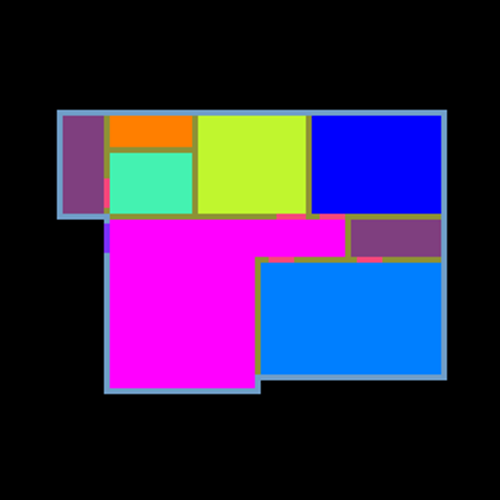

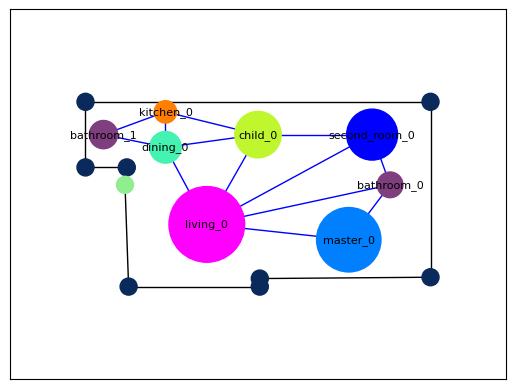

In [ ]:
Graph_index = 1911
G = createGraph(Graph_index)
b = Handling_dubplicated_nodes(Graph_index)

draw_graph_nodes(G);
plot_plan_colored(Graph_index, df);
draw_graph_boundary(b);

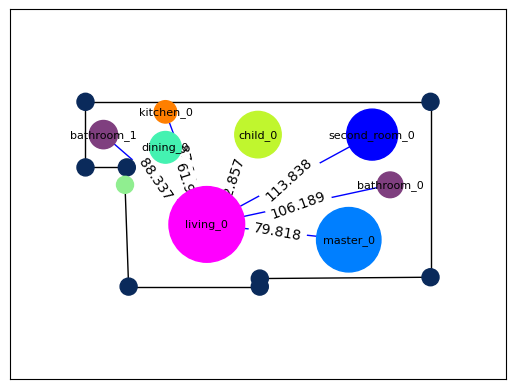

In [ ]:
G_living_to_all = createGraph(Graph_index, living_to_all=True)
# b = Handling_dubplicated_nodes(Graph_index)

draw_graph_nodes(G_living_to_all, living_to_all=True);
draw_graph_boundary(b);

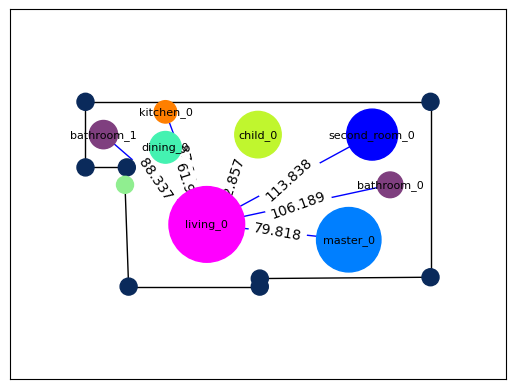

In [ ]:
G_living_to_all = createGraph(Graph_index, living_to_all=True)
# b = Handling_dubplicated_nodes(Graph_index)

draw_graph_nodes(G_living_to_all, living_to_all=True);
draw_graph_boundary(b);

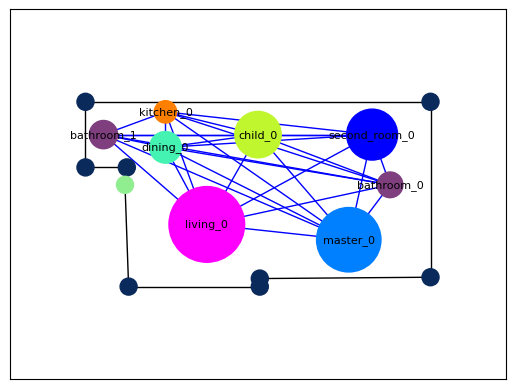

In [ ]:
G_all_conected = createGraph(Graph_index, all_conected=True)
b = Handling_dubplicated_nodes(Graph_index)

draw_graph_nodes(G_all_conected);
draw_graph_boundary(b);

In [ ]:
type(df_rooms_polys_dict)

pandas.core.series.Series

In [ ]:
len(df_rooms_polys_dict[1])

14

In [ ]:
for idx in tqdm(range(len(df_rooms_polys_dict))):
  print(idx)

In [ ]:
graph_index = df_rooms_polys_dict[5]

In [ ]:
graph_index

{'living': [<POLYGON ((95 91, 95 101, 114 101, 115 102, 115 192, 169 192, 169 119, 170 1...>],
 'master': [<POLYGON ((95 107, 95 132, 94 133, 64 133, 64 192, 109 192, 109 107, 95 107))>],
 'kitchen': [<POLYGON ((157 55, 157 101, 183 101, 183 55, 157 55))>],
 'bathroom': [<POLYGON ((175 124, 175 144, 216 144, 216 124, 175 124))>,
  <POLYGON ((64 91, 64 127, 89 127, 89 91, 64 91))>],
 'dining': [],
 'child': [],
 'study': [],
 'second_room': [<POLYGON ((40 44, 40 85, 109 85, 109 44, 40 44))>,
  <POLYGON ((115 34, 115 85, 151 85, 151 34, 115 34))>],
 'guest': [],
 'balcony': [<POLYGON ((111 198, 111 222, 169 222, 169 198, 111 198))>],
 'storage': [],
 'entrance': [],
 'front_door': [<POLYGON ((187 102, 187 106, 201 106, 201 102, 187 102))>],
 'interior': [<POLYGON ((126 193, 126 197, 150 197, 150 193, 126 193))>,
  <POLYGON ((176 119, 176 123, 190 123, 190 119, 176 119))>,
  <POLYGON ((94 102, 94 105, 93 106, 90 106, 90 128, 94 128, 94 107, 95 106, 1...>,
  <POLYGON ((152 89, 152 103, 156

In [ ]:
createGraph(5)

In [ ]:
Graphs_real = []
Graphs_living_to_all = []
Graphs_all_conected = []
boundaries = []

for idx in tqdm(range(len(df_rooms_polys_dict))):
    # graph as real floot plan
    graph_index = idx
    G_real = createGraph(graph_index)

    # graph with connecting only living with all geoms
    G_living_to_all = createGraph(graph_index, living_to_all=True)

    # graph with each room connected to all others
    G_all_conected = createGraph(graph_index, all_conected=True)

    # graph of the boundary
    b = Handling_dubplicated_nodes(idx)

    Graphs_real.append(G)
    Graphs_living_to_all.append(G_living_to_all)
    Graphs_all_conected.append(G_all_conected)
    boundaries.append(b)

100%|██████████| 80787/80787 [21:25<00:00, 62.83it/s]


In [ ]:
path = '/content/drive/MyDrive/RPlanify_dataset'
if not os.path.exists(path):
    os.makedirs(path)

print(os.getcwd())

/content


In [ ]:
with open('/content/drive/MyDrive/RPlanify_dataset/graphs/Graphs_real.pkl', 'wb') as f:
    pickle.dump(Graphs_real, f)


In [ ]:
with open('/content/drive/MyDrive/RPlanify_dataset/graphs/Graphs_living_to_all.pkl', 'wb') as f:
    pickle.dump(Graphs_real, f)

In [ ]:
with open('/content/drive/MyDrive/RPlanify_dataset/graphs/Graphs_all_conected.pkl', 'wb') as f:
    pickle.dump(Graphs_all_conected, f)

In [ ]:
with open('/content/drive/MyDrive/RPlanify_dataset/graphs/boundaries.pkl', 'wb') as f:
    pickle.dump(boundaries, f)

In [ ]:
!pip install distinctipy -q
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [ ]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool

url = "/content/drive/MyDrive/RPlanify_dataset/graphs/Graphs_real.pkl"

In [ ]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [ ]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}

    scales = [G.nodes[node]['roomSize'] * 10000 for node in G]
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]

    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)

    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100

    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def collate_fn(graphs_list):
    batch = Batch.from_data_list([Data.from_(g) for g in graphs_list])
    return batch

Graph with 8 nodes and 13 edges


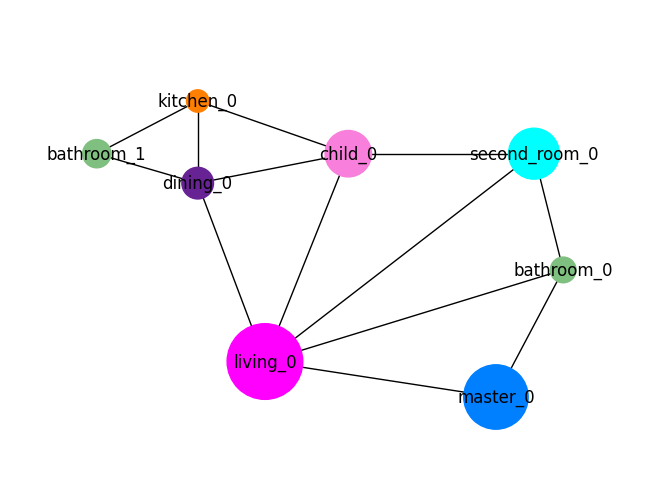

In [ ]:
with open(url, 'rb') as f:
    Graphs = pickle.load(f)

G = Graphs[1911]
print(G)
draw_graph(G)

In [ ]:
features = ['actualCentroid_x', 'actualCentroid_y', 'rec_w', 'rec_h', 'roomSize']


In [ ]:
# Converting networkx graphs to pytorchGeo graphs
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features)
    # Normalizing feature matrix (x)
    G_new = T.NormalizeFeatures()(G_new)

    Graphs_pyTorch.append(G_new)

Graphs_pyTorch[0]

100%|██████████| 80787/80787 [01:55<00:00, 697.08it/s]


Data(edge_index=[2, 26], roomType_name=[8], roomType_embd=[8], distance=[26], x=[8, 5])

In [ ]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].roomType_embd}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.roomType_embd):
        if value in [1, 4, 5, 6, 7, 8]:
            G.roomType_embd[j] = 1

        # making all labels from 0 to 6 only to help one_hotting
        elif value == 9:
            G.roomType_embd[j] = 4
        elif value == 10:
            G.roomType_embd[j] = 5
        elif value == 11:
            G.roomType_embd[j] = 6
print(f'After: G_1 embedings are: {Graphs_pyTorch[1].roomType_embd}')

Befor: G_1 embedings are: tensor([0, 1, 3, 4, 5, 7, 2, 3])


100%|██████████| 80787/80787 [00:30<00:00, 2661.60it/s]

After: G_1 embedings are: tensor([0, 1, 3, 1, 1, 1, 2, 3])


In [ ]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr

#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

In [ ]:
class Planify_Dataset(Dataset):
    def __init__(self, data):
        self.Graphs = data

    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone()
        # shuffling nodes inside the same graph
        permutation = torch.randperm(G.num_nodes)

        G.x = G.x[permutation]
        G.edge_index = permutation[G.edge_index]
        G.roomType_embd = G.roomType_embd[permutation]
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)

        return G

In [ ]:

batch_size = 128
dataset = Planify_Dataset(Graphs_pyTorch[1:])
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, nu_classes):
        super().__init__()
        self.gc1 = GATConv(input_channels, hidden_channels, heads=8)
        self.gc2 = GATConv(hidden_channels * 8, hidden_channels * 8, heads=8)
        self.gc3 = GATConv(hidden_channels * 8 * 8, hidden_channels * 8, heads=8)

        self.fc1 = nn.Linear(hidden_channels * 8 * 8, nu_classes * 8)
        self.fc2 = nn.Linear(nu_classes * 8, nu_classes)

        self.Classifier = nn.Linear(nu_classes, nu_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.gc1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, training=self.training)

        x = self.gc2(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, training=self.training)

        x = self.gc3(x, edge_index)
        x = x.relu()

        x = self.fc1(x)
        x = x.relu()

        x = self.fc2(x)
        x = x.relu()

        x = self.Classifier(x)
        x = self.Classifier(x)

        return x.relu()



nu_features    = Graphs_pyTorch[0].x.shape[0]
# number_classes = 12 # there is 12 distict classes in our dataset
number_classes = 7 # if we consider all rooms has the same label = 1


model = GCN(nu_features, hidden_channels=16, nu_classes=number_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# to monitor the loss & accuracy.
errors = []
acc = []
model

GCN(
  (gc1): GATConv(8, 16, heads=8)
  (gc2): GATConv(128, 128, heads=8)
  (gc3): GATConv(1024, 128, heads=8)
  (fc1): Linear(in_features=1024, out_features=56, bias=True)
  (fc2): Linear(in_features=56, out_features=7, bias=True)
  (Classifier): Linear(in_features=7, out_features=7, bias=True)
)

In [ ]:
# Hyperparameters
learning_rate = 0.001
nu_epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.972)

# def scheduler(epoch, lr)
#     if epoch < 20:
#         return lr
#     else:
#         return lr * 0.99

In [ ]:
# Saving model function
import os

# checkpoint_dir = '/kaggle/working/checkpoints'
# checkpoint_dir = '/media/mo/DATA/Grad/Planify_Dataset/Graph/checkpoints'
checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
    # Saving model each 15 epochs
    if epoch % 20 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }, checkpoint_path)

        print('Model saved :)')

In [ ]:
for epoch in range(nu_epochs):
    running_loss = 0.0
    train_acc    = 0.0
    for i, data in tqdm(enumerate(loader), desc='Planifying', total=len(loader)):
        optimizer.zero_grad()

        # Forward pass
        logits    = model(data.to(device)).to(device)

        # print(logits.shape)
        # one_hot_y = F.one_hot(data.roomType_embd, num_classes=number_classes).float()
        # computing loss through crossEntropy loss function
        loss = criterion(logits, data.roomType_embd)

        # Backward pass
        loss.backward()

        # Updating parameters
        optimizer.step()
        # current_lr = optimizer.param_groups[0]['lr']
        # optimizer = torch.optim.Adam(model.parameters(), lr=scheduler(epoch, current_lr))

        # Monitoring
        running_loss += loss.item()
        train_acc += (torch.argmax(logits, 1).flatten() == data.roomType_embd).type(torch.float).mean().item()
        lr = optimizer.param_groups[0]['lr']


    print(data.roomType_embd[:10])
    print(torch.argmax(logits, 1)[:10])

    errors.append(running_loss/batch_size)
    acc.append(train_acc/batch_size)

    # Updating scheduler each 15 epochs.
    scheduler.step()

    # Saving the model.
    save_checkpoint(model, optimizer, epoch)

    # Monitoring and printing.
    batch_size = len(loader)
    print(f'Epoch: {epoch + 1}/{nu_epochs} | lr: {lr} | avg_loss: {running_loss/batch_size:.5f} | training_acc: {train_acc/batch_size * 100:.5f}%')

In [ ]:
# plt.plot(errors);
plt.plot(acc, label='accuracy');
plt.plot(errors, label='error');
plt.xlabel('Epochs')
plt.title('Monitoring the model')
plt.legend();

In [ ]:
idx = random.randint(0, len(Graphs_pyTorch))
G = Graphs_pyTorch[idx].to(device)
logits = model(G)
predicts = torch.argmax(logits, 1)

print(f'The real values: {G.roomType_embd}')
print(f'Predicted values: {predicts}')

In [ ]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
# !pip install distinctipy -q
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import distinctipy
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# for my pc
url_living_to_all = "D:\Grad\Planify_Dataset\Planify_Graphs_Scaled\Graphs_living_to_all.pkl"
url_boundary = r"D:\Grad\Planify_Dataset\Planify_Graphs_Scaled\boundaries.pkl"

# # for kaggle
# url_real = "/kaggle/input/planify-graphs-all-forms/graphs/Graphs_real.pkl"
# url_boundary = "/kaggle/input/planify-graphs-all-forms/graphs/boundaries.pkl"

In [ ]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [ ]:

def draw_graph_nodes(G, living_to_all=False):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}

    scales = [G.nodes[node]['roomSize'] * 10000 for node in G]
    color_map = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    edge_labels = nx.get_edge_attributes(G, 'distance')


    nx.draw_networkx_nodes(G, pos=pos, node_size=scales, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos, edge_color='b');
    nx.draw_networkx_labels(G, pos=pos, font_size=8);

    if living_to_all:
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


    # # Drawing the graph inside a good boundary.
    # x_coords  = [pos[node][0] for node in pos]
    # y_coords  = [pos[node][1] for node in pos]
    # threshold = max(scales) / 100

    # plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)

def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}

    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]

    # nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)
    nx.draw_networkx_nodes(G, pos=pos, node_size=150, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos)

    plt.xlim(-10, 266)
    plt.ylim(-266, 10)

# For statistics
def get_max_min_x_y(graphs):
    max_x = 0
    max_y = 0
    min_x = float('inf')
    min_y = float('inf')

    for G in tqdm(graphs, desc="Getting maximum x, y", total=len(graphs)):
        max_x_in_graph = G.x.T[1].max().item()
        max_y_in_graph = G.x.T[2].max().item()

        min_x_in_graph = G.x.T[1].min().item()
        min_y_in_graph = G.x.T[2].min().item()

        if max_x_in_graph > max_x:
            max_x = max_x_in_graph
        if max_y_in_graph > max_y:
            max_y = max_y_in_graph

        if min_x_in_graph < min_x:
            min_x = min_x_in_graph
        if min_y_in_graph < min_y:
            min_y = min_y_in_graph

    values = {'max_x': max_x, 'max_y': max_y, 'min_x': min_x, 'min_y': min_y}
    return values

def get_all_x_y(graphs):
    """Get all values of x and y from all graphs
        Input: list of graphs
        Output: x and y as pandas series
    """
    x = []
    y = []
    for i, G in tqdm(enumerate(graphs), desc="getting all Xs, Ys", total=len(graphs)):
        for i in range(len(G.x)):
            x.append(G.x[i][1].item())
            y.append(G.x[i][2].item())


    x = pd.Series(x)
    y = pd.Series(y)

    return x, y

def boxplot_centrValues(x, y):
    fig, ax = plt.subplots()

    # Plot the boxplots
    ax.boxplot([x, y])

    # Set the xtick labels
    ax.set_xticklabels(['x', 'y'])

    # Add axis labels and title
    ax.set_xlabel('Data')
    ax.set_ylabel('Value')
    ax.set_title('Boxplot of x and y in all graphs')

    # Show the plot
    plt.show()

def plot_histograms(x, y):
    x.hist(density=True, bins=100, alpha=0.6, label='x');
    y.hist(density=True, bins=100, alpha=0.3, label='y');
    plt.legend();
    plt.title('Distribution of x and y');

In [ ]:
with open(url_living_to_all, 'rb') as f:
    Graphs = pickle.load(f)

G = Graphs[1911]
print(G)

In [ ]:
with open(url_boundary, 'rb') as f:
    boundaries = pickle.load(f)

b = boundaries[1911]
print(b)

In [ ]:
draw_graph_boundary(b)
draw_graph_nodes(G)

In [ ]:
def convert_networkx_Graphs_to_pyTorchGraphs(G):
    """ Converting networkx graphs to pytorchGeo graphs
    """
    features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    return G_new

Graphs_pyTorch = list(map(convert_networkx_Graphs_to_pyTorchGraphs, Graphs))

Graphs_pyTorch[0]

In [ ]:

def convert_networkx_Boundaries_to_pyTorchGraphs(b):
    """Converting networkx boundary graphs to PyTorchGeo graphs
    """
    b_new = from_networkx(b, group_node_attrs=['type', 'centroid'], group_edge_attrs=['distance'])
    return b_new

Boundaries_pyTorch = list(map(convert_networkx_Boundaries_to_pyTorchGraphs, boundaries))

Boundaries_pyTorch[0]

In [ ]:
G_x, G_y = get_all_x_y(Graphs_pyTorch)
G_x.max(), G_y.max(), G_x.min(), G_y.min()

In [ ]:
boxplot_centrValues(G_x, G_y)
plot_histograms(G_x, G_y)

print("And we saw the box plots so there is no outliers, and the distribution is normal")
G_x_mean = G_x.mean()
G_y_mean = G_y.mean()
G_x_std  = G_x.std()
G_y_std  = G_y.std()
print("We will use z-score normalization")

In [ ]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())

        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1

        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6


print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

In [ ]:

for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):

    # Making tensor of means = [x_mean, y_mean] & tensor of stds = [x_std, y_std].
    # We could make a tensor of ones = [rows, 2] then multiply it by the means, But we directly
    # multiply the means using the idea of "Broadcasting".
    G.x[:, 1:] = (G.x[:, 1:] - torch.tensor([G_x_mean, G_y_mean])) / torch.tensor([G_x_std, G_y_std])

    # One hot encoding for the first column [type of rooms]
    first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)

    G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

In [ ]:

return_to_real = Graphs_pyTorch[1].x[:, [-2, -1]] * torch.tensor([G_x_std, G_y_std]) + torch.Tensor([G_x_mean, G_y_mean])
print(f"Now, we could return back to real values: \n{return_to_real}")

In [ ]:

B_x, B_y = get_all_x_y(Boundaries_pyTorch)
B_x.max(), B_y.max(), B_x.min(), B_y.min()

In [ ]:
boxplot_centrValues(B_x, B_y)

In [ ]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
B_x_mean = B_x.mean()
B_y_mean = B_y.mean()
B_x_std  = B_x.std()
B_y_std  = B_y.std()
print("We will use z-score normalization")

In [ ]:
for b in tqdm(Boundaries_pyTorch, total=len(Boundaries_pyTorch)):

    # Making tensor of means = [x_mean, y_mean] & tensor of stds = [x_std, y_std].
    # We could make a tensor of ones = [rows, 2] then multiply it by the means, But we directly
    # multiply the means using the idea of "Broadcasting".
    b.x[:, 1:] = (b.x[:, 1:] - torch.tensor([B_x_mean, B_y_mean])) / torch.tensor([B_x_std, B_y_std])

In [ ]:

return_to_real = Boundaries_pyTorch[1].x[:, [-2, -1]] * torch.tensor([B_x_std, B_y_std]) + torch.Tensor([B_x_mean, B_y_mean])
print(f"Now, we could return back to real values: \n{return_to_real}")

In [ ]:
class Planify_Dataset(Dataset):
    def __init__(self, Graphs, Boundaries):
        self.Graphs = Graphs
        self.Boundaries = Boundaries
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(self.device)
        B = self.Boundaries[index].clone().to(self.device)
        B.x = B.x.to(G.x.dtype)
        B.edge_index = B.edge_index.to(G.edge_index.dtype)
        B.edge_attr = B.edge_attr.to(G.edge_attr.dtype)

        # shuffling nodes inside the same graph
        # permutation = torch.randperm(G.num_nodes).to(self.device)

        # G.x = G.x[permutation]
        # G.edge_index = permutation[G.edge_index]
        # G.rec_w = G.rec_w[permutation]
        # G.rec_h = G.rec_h[permutation]
        # G.edge_attr = G.edge_attr[permutation]

        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        graphs = {
            'G': G,
            'B': B
        }

        return graphs

In [ ]:
edge = int(len(Graphs_pyTorch) * 0.8)


In [ ]:
batch_size = 32
train_dataset = Planify_Dataset(Graphs_pyTorch[:edge], Boundaries_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = Planify_Dataset(Graphs_pyTorch[edge:-10], Boundaries_pyTorch[edge:-10])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Planify_Dataset(Graphs_pyTorch[-10:], Boundaries_pyTorch[-10:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"Train dataset: {len(train_dataset)}, Val dataset: {len(val_dataset)}, Test dataset: {len(test_dataset)}")

In [ ]:
# Saving model function
import os

checkpoint_dir = "/content/drive/MyDrive/RPlanify_dataset/checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'Best_model_V3.pt')
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)

    print('Model saved :)')

In [ ]:
class GATNet(torch.nn.Module):
    def __init__(self, num_graph_node_features, num_boundary_node_features):
        super(GATNet, self).__init__()

        self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=4)

        input_of_conv2   = num_graph_node_features + 32*4
        self.graph_conv2 = GATConv(input_of_conv2, 32, heads=8)

        input_of_conv3   = num_graph_node_features + 32*8
        self.graph_conv3 = GATConv(input_of_conv3, 64, heads=8)

        input_of_conv4   = num_graph_node_features + 64*8
        self.graph_conv4 = GATConv(input_of_conv4, 128, heads=8)
        # self.graph_conv5 = GATConv(128*8, 128, heads=8)
        # self.graph_conv6 = GATConv(128*8, 128, heads=16)
        # self.graph_conv7 = GATConv(128*16, 256, heads=16)
        # self.graph_conv8 = GATConv(256*16, 256, heads=16)
        shape_of_graphs_befor_concatination = num_graph_node_features + 128*8

        self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=4)
        input_of_boundary_conv2 = 32*4 + num_boundary_node_features
        self.boundary_conv2 = GATConv(input_of_boundary_conv2, 32, heads=8)
        # self.boundary_conv3 = GATConv(32*8, 64, heads=8)
        # self.boundary_conv4 = GATConv(64*8, 128, heads=8)
        # self.boundary_conv5 = GATConv(128*8, 128, heads=8)
        shape_of_boundary_befor_concatination = num_boundary_node_features + 32 * 8

        # Output of graph_conv8 + output of boundary_conv5 + 2 step connection from real nodes and boundary nodes
        inputs_concatination = shape_of_graphs_befor_concatination + shape_of_boundary_befor_concatination
        self.Concatination1  = GATConv(inputs_concatination, 128, heads=8)
        # self.Concatination2  = GATConv(128*8, 64, heads=8)
        # self.Concatination3  = GATConv(64*8, 64, heads=8)
        # self.Concatination4  = GATConv(64*8, 32, heads=8)
        # self.Concatination5  = GATConv(32*8, 32*4)

        # self.lin1 = nn.Linear(inputs_concatination, 256)
        # self.lin2 = nn.Linear(256, 32)

        self.width_layer1  = nn.Linear(128*8, 128)
        self.height_layer1 = nn.Linear(128*8, 128)

        # self.width_layer2  = nn.Linear(256, 128)
        # self.height_layer2 = nn.Linear(256, 128)

        # self.width_layer3  = nn.Linear(128, 32)
        # self.height_layer3 = nn.Linear(128, 32)

        # self.width_layer4  = nn.Linear(32, 8)
        # self.height_layer4 = nn.Linear(32, 8)

        self.width_output  = nn.Linear(128, 1)
        self.height_output = nn.Linear(128, 1)


        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, graph, boundary):
        x_graph, g_edge_index, g_edge_attr, g_batch = graph.x, graph.edge_index, graph.edge_attr, graph.batch
        x_boundary, b_edge_indexy, b_edge_attr, b_batch = boundary.x, boundary.edge_index, boundary.edge_attr, boundary.batch

        NUM_OF_NODES = x_graph.shape[0]
        # During testing, as we input only one graph.
        if g_batch == None:
            g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long)
        if b_batch == None:
            b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long)


        x_graph_res = x_graph
        x_boundary_res = x_boundary

        # Passing the graph throught a message passing to embed its features
        x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph) # Concatinate with step connection from real values.
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)


        x_graph = F.leaky_relu(self.graph_conv2(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)

        x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)

        x_graph = F.leaky_relu(self.graph_conv4(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)

        # x_graph = F.leaky_relu(self.graph_conv5(x_graph, g_edge_index))
        # x_graph = F.leaky_relu(self.graph_conv6(x_graph, g_edge_index))
        # x_graph = self.dropout(x_graph)
        # x_graph = F.leaky_relu(self.graph_conv7(x_graph, g_edge_index))
        # x_graph = F.leaky_relu(self.graph_conv8(x_graph, g_edge_index))
        # x_graph = self.dropout(x_graph)


        # Passing the boundary throught a message passing to embed its features
        x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)

        x_boundary = F.leaky_relu(self.boundary_conv2(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)

        # x_boundary = F.leaky_relu(self.boundary_conv3(x_boundary, b_edge_indexy))
        # x_boundary = self.dropout(x_boundary)
        # x_boundary = F.leaky_relu(self.boundary_conv4(x_boundary, b_edge_indexy))
        # x_boundary = F.leaky_relu(self.boundary_conv5(x_boundary, b_edge_indexy))
        # x_boundary = self.dropout(x_boundary)

        # Pooling the bounadry to 1D vector by getting max value in each feature for all nodes.
        x_boundary_pooled = F.max_pool1d(x_boundary.transpose(0, 1), kernel_size=x_boundary.shape[0]).view(1, -1)

        # Concatinating the graph & the boundary
        x = torch.cat([x_graph, x_boundary_pooled.repeat(NUM_OF_NODES, 1)], dim=1)
        x = F.leaky_relu(self.Concatination1(x, g_edge_index))
        x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination2(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination3(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination4(x, g_edge_index))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.Concatination5(x, g_edge_index))
        # x = self.dropout(x)

        # x = F.leaky_relu(self.lin1(x))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.lin2(x))
        # x = self.dropout(x)


        width = F.leaky_relu(self.width_layer1(x))
        # width = F.leaky_relu(self.width_layer2(width))
        # width = F.leaky_relu(self.width_layer3(width))
        # width = F.leaky_relu(self.width_layer4(width))
        width = self.dropout(width)
        width = self.width_output(width)

        height = F.leaky_relu(self.height_layer1(x))
        # height = F.leaky_relu(self.height_layer2(height))
        # height = F.leaky_relu(self.height_layer3(height))
        # height = F.leaky_relu(self.height_layer4(height))
        height = self.dropout(height)
        height = self.height_output(height)

        return width.squeeze(), height.squeeze()

num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]

model = GATNet(num_graph_node_features, num_boundary_node_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# to monitor the loss & accuracy.
errors = []
acc = []

model

In [ ]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        graph, boundary = data['G'], data['B']

        width, height    = model(graph, boundary)

        width_loss = criterion(width, graph.rec_w)
        height_loss = criterion(height, graph.rec_h)

        loss = width_loss + height_loss

        # Backward pass
        loss.backward()

        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()

    return running_loss / len(train_loader)


def evaluate(model, criterion, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            graph, boundary = data['G'], data['B']
            width, height    = model(graph, boundary)
            width_loss = criterion(width, graph.rec_w)
            height_loss = criterion(height, graph.rec_h)

            loss = width_loss + height_loss
            running_loss += loss.item()

    return running_loss / len(val_loader)

In [ ]:
from copy import deepcopy

# Hyperparameters
learning_rate = 0.001
num_epochs = 250
patience = 10 # Number of epochs to wait if validation loss doesn't improve
best_val_loss = float('inf')

counter = 0

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=3e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.950)

In [ ]:
# Notice
train_losses = []
val_losses = []

In [ ]:
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)

    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)

    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0

    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

In [ ]:
counter = 0
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)

    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)

    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0

    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

In [ ]:
counter = 0
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)

    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)

    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0

    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

In [ ]:
plt.plot(train_losses, label=f'Best training    loss: {min(train_losses):.0f}');
plt.plot(val_losses, label=f'Best validation loss: {min(val_losses):.0f}');
plt.legend();

In [ ]:
checkpoint_path = r"D:\Grad\Best models\v3_UnScalled\Best_model_V3.pt"
checkpoint = torch.load(checkpoint_path)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']

model.eval()

In [ ]:
class FloorPlan_multipolygon():
    def __init__(self, graph, prediction=None):
        self.graph       = graph
        self.prediction  = prediction

    def get_room_data(self, room_index):
        """
        Inputs:
            room_index: index of the room in the graph

        Outputs:
            centroid, w, h of that room.
        """
        # # Using networkX graphs
        # Graph_data = list(self.graph.nodes(data=True))[room_index][1]
        # w = Graph_data['rec_w']
        # h = Graph_data['rec_h']
        # centroid = (Graph_data['actualCentroid_x'], Graph_data['actualCentroid_y'])
        # category = Graph_data['roomType_embd']

        # Using pytorhc Garphs
        w = self.graph.rec_w[room_index].item()
        h = self.graph.rec_h[room_index].item()
        centroid = (self.graph.x[room_index][-2].item(), self.graph.x[room_index][-1].item())
        category = torch.argmax(self.graph.x[:, :7][room_index]).item()

        if isinstance(self.prediction, tuple): # A  real array of predictions
            w_pre, h_pre = self.get_predictions(room_index)

        else:
            w_pre, h_pre = None, None

        data = {
            'centroid': centroid,
            'real_w': w,
            'real_h': h,
            'predic_w': w_pre,
            'predic_h': h_pre,
            'category': category
        }
        return data

    def create_box(self, room_data):
        """
        Inputs:
            room_data: a dictionary with centroid, w, h of that room.

        Outputs:
            box: a shapely box with the same centroid, w, h of that room.
        """

        centroid = room_data['centroid']
        # print(centroid)
        if isinstance(self.prediction, tuple): # A  real array of predictions
            half_w   = room_data['predic_w'] / 2
            half_h   = room_data['predic_h'] / 2

        else:
            half_w   = room_data['real_w'] / 2
            half_h   = room_data['real_h'] / 2

        # bottom_left  = Point(centroid[0] - half_w, centroid[1] - half_h)
        # bottom_right = Point(centroid[0] + half_w, centroid[1] - half_h)
        # top_right    = Point(centroid[0] + half_w, centroid[1] + half_h)
        # top_left     = Point(centroid[0] - half_w, centroid[1] + half_h)

        x1 = centroid[0] - half_w
        x2 = centroid[0] + half_w
        y1 = centroid[1] - half_h
        y2 = centroid[1] + half_h

        # print(bottom_left, bottom_right, top_right, top_left)
        # box = Polygon([bottom_left, bottom_right, top_right, top_left])
        box_poly = box(x1, y1, x2, y2)
        return box_poly

    def get_multipoly(self, boundary=False, door=False):
        """
        Outputs:
            multi_poly: a shapely multipolygon of all the rooms in the floor plan or graph.
        """
        num_of_rooms = self.graph.x.shape[0]
        similar_polygons = defaultdict(list)

        for index in range(num_of_rooms):
            room_data = self.get_room_data(index)
            box = self.create_box(room_data)
            box = box.intersection(boundary.buffer(-3, cap_style=3, join_style=2))

            # add each pox to its similar boxes
            room_category = room_data['category']
            if room_category != 0:
                similar_polygons[room_category].append(box)


        all_polygons = []
        all_polygons.append(boundary)
        similar_polygons_2 = defaultdict(list)
        for room_category, polygons in similar_polygons.items():
            if room_category in (2, 3): # If bathroom or kitchen.
                # combined_polygon = unary_union(polygons)
                # all_polygons.append(combined_polygon)
                # for poly in polygons:
                #     similar_polygons_2[room_category].append(poly)

                for bath_or_kitchen in polygons:
                    if any(bath_or_kitchen.intersects(room) for room in similar_polygons[1]): # Chcek if the current bathroom or kitchen intersectes with any room
                        for i, room in enumerate(similar_polygons[1]):
                            if bath_or_kitchen.intersects(room):
                                intersection = bath_or_kitchen.intersection(room)
                                if intersection.area >= (0.3 * bath_or_kitchen.area):
                                    # new_bath_or_kitchen = intersection
                                    print('>= 50%')
                                    bath_or_kitchen = bath_or_kitchen.intersection(room.buffer(-3, cap_style=3, join_style=2))
                                    # bath_or_kitchen   = room.intersection(bath_or_kitchen.buffer(-3, cap_style=3, join_style=3))
                                else:
                                    print('Not >= 50%')
                                    ## If we need to cut from the room
                                    # new_room = room.difference(intersection.buffer(50))
                                    # similar_polygons[1][i] = new_room

                                    ## If we need to cut from the bathroom or kitchen
                                    bath_or_kitchen = bath_or_kitchen.difference(intersection.buffer(4))

                    similar_polygons_2[room_category].append(bath_or_kitchen)

            else: # If rooms
                existing_polygons = []
                for poly in polygons: # for room in rooms
                    # print(f'Current poly: {poly.centroid}')
                    if any(poly.intersects(exist) for exist in existing_polygons):
                        for exist in existing_polygons:
                            if poly.intersects(exist): # If there is an intersection between current poly and the checking polygon.
                                # print(f'Intersects with: {exist.centroid}')
                                intersection = poly.intersection(exist)
                                if exist.area > poly.area:
                                    # print('1')
                                    difference_polygon = exist.difference(intersection.buffer(4))

                                    # We cut from the exist so we will remove the old version and add the new version.
                                    similar_polygons_2[room_category].remove(exist)
                                    similar_polygons_2[room_category].append(difference_polygon)

                                    # Also we add the current polygon.
                                    similar_polygons_2[room_category].append(poly)

                                    # The same step we didi in similar_polygons_2 we make it here to make the existing_polys the same.
                                    existing_polygons.remove(exist)
                                    existing_polygons.append(difference_polygon)

                                    existing_polygons.append(poly)

                                else:
                                    # print('2')
                                    difference_polygon = poly.difference(intersection.buffer(4))
                                    similar_polygons_2[room_category].append(difference_polygon)
                                    # existing_polygons.append(difference_polygon)
                                    # similar_polygons_2[room_category].append(exist)

                    else: # For the first one
                        # print('No intersection')
                        existing_polygons.append(poly)
                        similar_polygons_2[room_category].append(poly)


        for _, polygons in similar_polygons_2.items():
            all_polygons.append(MultiPolygon(polygons))

        if door:
            all_polygons.append(door)

        compined_polygons_seperated = gpd.GeoSeries(all_polygons)

        return compined_polygons_seperated

    def get_predictions(self, room_index):
        """
        Inputs:
            room_index: index of the room in the graph
        outputs:
            w_predicted: predicted width for that room
            h_predicted: predicted width for that room
        """
        w_predicted = self.prediction[0]
        h_predicted = self.prediction[1]

        return w_predicted[room_index], h_predicted[room_index]

In [ ]:
# rand = np.random.randint(0, 80000)
Graph_index = -7
print(Graph_index)
# Graph and Boundary with normalized x, y
G = Graphs_pyTorch[Graph_index]
B = Boundaries_pyTorch[Graph_index]

# Using the same data types in boundaries as in graphs, must for the model.
B.x = B.x.to(G.x.dtype)
B.edge_index = B.edge_index.to(G.edge_index.dtype)
B.edge_attr = B.edge_attr.to(G.edge_attr.dtype)

# Get our predictions
predictions = model(G.to(device), B.to(device))


# Get back the real x, y of the centroids to put them in their real places.
G = Graphs_pyTorch[Graph_index]
G.x[:, -2] = G.x[:, -2] * x_g_std + x_g_mean
G.x[:, -1] = G.x[:, -1] * y_g_std + y_g_mean

B.x[:, -2] = B.x[:, -2] * x_b_std + x_b_mean
B.x[:, -1] = B.x[:, -1] * y_b_std + y_b_mean